In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [2]:
import numpyro
numpyro.set_host_device_count(2)

In [3]:
np.random.seed(987)

In [4]:
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):

        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        return solve_ivp(self.dydx, **kwargs)

In [5]:
my_model = PredatorPreyModel()

In [6]:
sol = my_model.solve(t_span=[0, 30], y0=np.array([10,5]), max_step=0.1)

In [7]:
noise = 0.1

t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

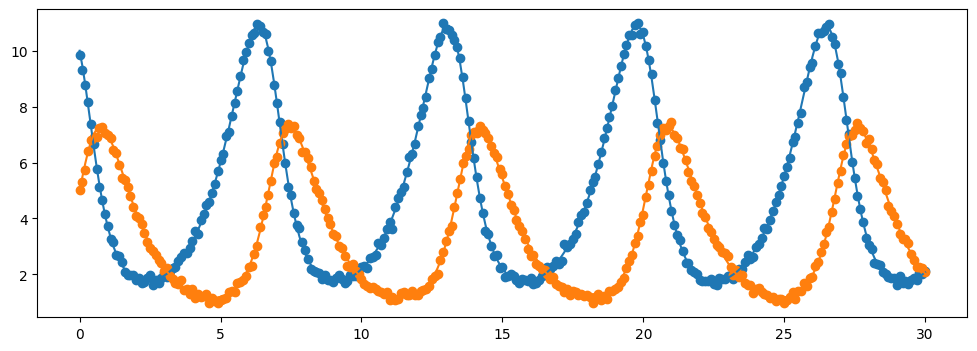

In [8]:
plt.figure(figsize=(12,4))

plt.plot(sol.t, sol.y[0,:])
plt.scatter(t, P)

plt.plot(sol.t, sol.y[1,:])
plt.scatter(t, Q)
plt.show()

In [9]:
optimizer = ps.optimizers.SBR(seed=123, num_warmup=500, num_samples=2000, num_chains=2)
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR())

In [10]:
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

In [11]:
sol = solve_ivp(surrogate_dydt, t_span=[0, 30], y0=np.array([10,5]), max_step=0.1)

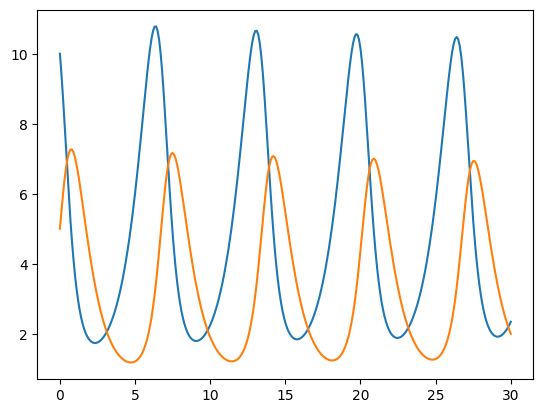

In [12]:
plt.plot(sol.t, sol.y.T)
plt.show()

In [13]:
import arviz as az

In [14]:
samples = az.from_numpyro(sindy.optimizer.mcmc)
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.019,0.106,-0.178,0.251,0.004,0.003,825.0,755.0,1.0
"beta[0, 1]",0.986,0.048,0.889,1.072,0.002,0.001,784.0,1045.0,1.0
"beta[0, 2]",0.005,0.041,-0.076,0.083,0.001,0.001,1208.0,998.0,1.0
"beta[0, 3]",-0.001,0.005,-0.010,0.009,0.000,0.000,868.0,223.0,1.0
"beta[0, 4]",-0.296,0.008,-0.310,-0.280,0.000,0.000,2142.0,2051.0,1.0
"beta[0, 5]",-0.002,0.007,-0.016,0.012,0.000,0.000,1615.0,1524.0,1.0
"beta[1, 0]",-0.003,0.127,-0.294,0.185,0.006,0.005,740.0,623.0,1.0
"beta[1, 1]",0.005,0.035,-0.060,0.072,0.001,0.001,806.0,677.0,1.0
"beta[1, 2]",-1.016,0.070,-1.156,-0.897,0.002,0.002,918.0,906.0,1.0
"beta[1, 3]",0.000,0.004,-0.007,0.008,0.000,0.000,1147.0,1042.0,1.0


[]

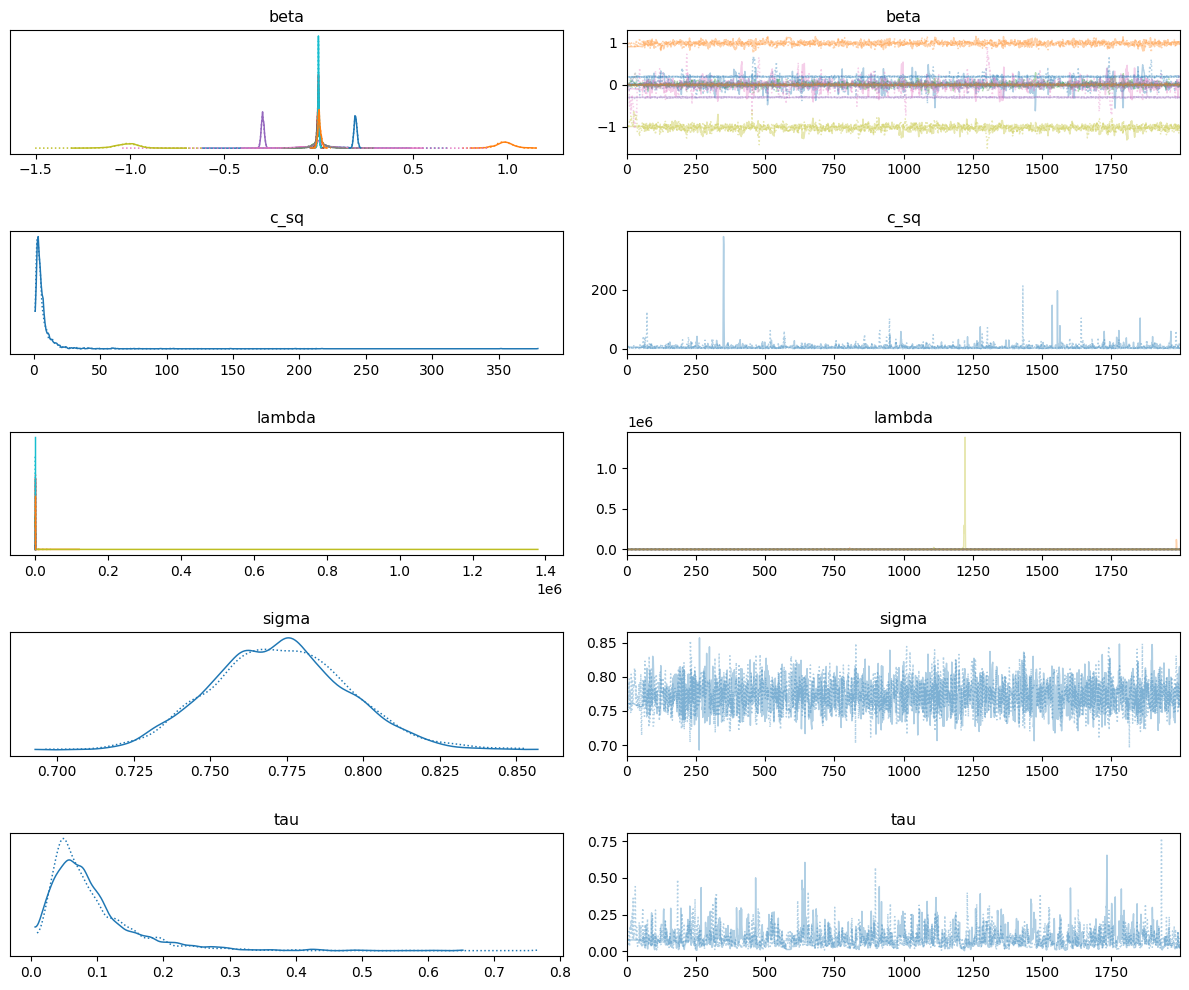

In [15]:
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()